In [15]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from ase.io import read

import subprocess
import sys

def install(name):
    subprocess.run(["pip","install", name])

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

In [16]:
try:
    from ase.io import read, write
    import ase.visualize
except ImportError:
    print("No ASE foun, installing it now")
    subprocess.run(["pip","install","ase"])
try:
    import pyGDM2
except ImportError:
    print("NO GDM found. Installing it now.")
    subprocess.run(["pip","install","pyGDM2"])

In [17]:
subprocess.run(["pip","install","--upgrade","--force-reinstall","pyGDM2"])

CompletedProcess(args=['pip', 'install', '--upgrade', '--force-reinstall', 'pyGDM2'], returncode=0)

In [18]:
def Optimise(Step, g, m):
    Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")

    while len(Struct.geometry) < len(g):
        Step -= 0.01
        Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")
    return Struct

In [19]:
Strut = read("Structures/Ag887_MDh453.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]

Struct = Optimise(2.77, g, m)

c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\tools.py:821: UserWarning: Inconsistent structure!!! 887 of 887 dipoles don't match with step=2.77nm.
  warnings.warn("Inconsistent structure!!! {} of {} dipoles don't match with step={:.2f}nm.".format(
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\structures.py:176: UserWarning: using only consistent part of structure. Please verify the geometry.
  warnings.warn(
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\structures.py:217: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")
c:\CMNP\CMNPs-main\venv\lib\site-packages\numpy\lib\_function_base_impl.py:552: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\CMNP\CMNPs-main\venv\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\CMNP\CMNPs-main\venv\lib\site-packages\pyGDM2\tools.py:821: UserWarning: Inconsistent structure!!! 887 of 

In [20]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)

kwargs_L = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2]) #Defines the left circularly polarized light coming in the xy plane along z in the positive direction
efield_L = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_L)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_L = core.simulation(Struct, efield_L, dyads)
sim_L.scatter(verbose=False)

kwargs_R = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[ np.pi/2]) #Defines the right circularly polarized light coming in the xy plane along z in the positive direction
efield_R = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_R)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_R = core.simulation(Struct, efield_R, dyads)
sim_R.scatter(verbose=False)

1

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}
Significant local maxima:
Value: 3988.957447048556, Index: 27


Text(0, 0.5, '$\\sigma_{ext}$ (nm$^2$)')

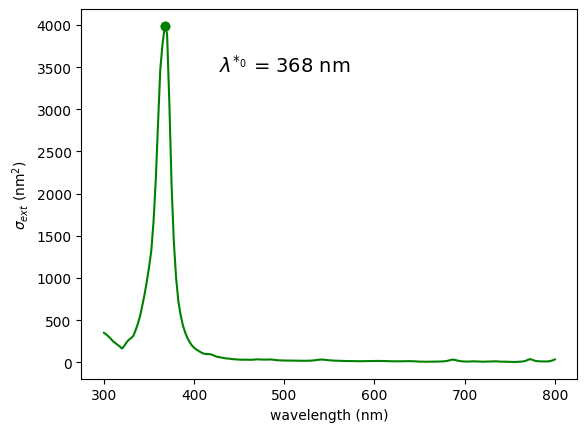

In [21]:
field_kwargs_L = tools.get_possible_field_params_spectra(sim_L)
for i, conf in enumerate(field_kwargs_L):
    print("config", i, ":", conf)
wl, spectrum_L = tools.calculate_spectrum(sim_L,field_kwargs_L[0] , linear.extinct)

spectrum_L = spectrum_L.T

peaks, _ = find_peaks(spectrum_L[0], height=0.05*np.amax(spectrum_L[0]))
# Print the significant local maxima
print("Significant local maxima:")
for peak in peaks:
    print(f"Value: {spectrum_L[0][peak]}, Index: {peak}")

plt.plot(wl, spectrum_L[0], 'g-', label='ext.')
plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color = 'g')
for i,peak in enumerate(peaks):
    plt.text(500, 0.85*np.amax(spectrum_L[0])-0.075*np.amax(spectrum_L[0])*i, "$\lambda^{*_{%s}}$ = " f'{wl[peak]:.0f} nm' %(i), ha='center', va='bottom', fontsize = 14)

plt.plot(wl[peaks], spectrum_L[0][peaks], "o", color='g', label='peaks')
plt.xlabel("wavelength (nm)")
plt.ylabel("$\sigma_{ext}$ (nm$^2$)")


In [22]:
def cmnp_plot(#1
              wl_target = 380, 
              z_probe = 0,
              projection = "XY"
              ):
    
    idx = tools.get_closest_field_index(sim_L, dict(wavelength=wl_target))

    wl, Cspec_L = tools.calculate_spectrum(sim_L, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_L = Cspec_L.T
    
    r_probe_L = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_L_t = linear.optical_chirality(sim_L, idx, r_probe_L, which_field='t')
    
    C_L_t[-1] -= 2 #Accounting for the sign of the L-CPL
     
    Es_L, Et_L, E0_L, Bs_L, Bt_L, B0_L  = linear.nearfield(sim_L, idx, r_probe=r_probe_L, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_L = np.amax(np.abs(Es_L[:,3].reshape(201,201))**2 + np.abs(Es_L[:,4].reshape(201,201))**2 + np.abs(Es_L[:,5].reshape(201,201))**2)
    wl, Cspec_R = tools.calculate_spectrum(sim_R, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_R = Cspec_R.T
    
    r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
    
    C_R_t[-1] += 2 #Accounting for the sign of the R-CPL
    
    Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_R = np.amax(np.abs(Es_R[:,3].reshape(201,201))**2 + np.abs(Es_R[:,4].reshape(201,201))**2 + np.abs(Es_R[:,5].reshape(201,201))**2)


    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(9, 9)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    plt.sca(axs[0,0])
    im_EL = visu.vectorfield_color(Et_L, show=0, ax=axs[0,0], cmap="viridis", vmin=0, vmax = 10, projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, projection=projection)
    
    plt.sca(axs[1,0])
    im_CL = visu.scalarfield(C_L_t, cmap='seismic', show=0, interpolation='nearest', vmin=-1, vmax=1, projection=projection)
    visu.structure_contour(sim_L, color='k', show=0, lw = 10, projection=projection)
    
    plt.sca(axs[0,1])
    im_ER = visu.vectorfield_color(Et_R, show=0, ax=axs[0,1], cmap="viridis", vmin=0, vmax = 10, projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, projection=projection)
    
    plt.sca(axs[1,1])
    im_CR = visu.scalarfield(C_R_t, cmap='seismic', show=0, interpolation='nearest', vmin=-1, vmax=1, projection=projection)
    visu.structure_contour(sim_R, color='k', show=0, lw = 10, projection=projection)

    axs[0,1].yaxis.set_label_position("right")
    axs[0,1].yaxis.tick_right()
    
    axs[1,1].yaxis.set_label_position("right")
    axs[1,1].yaxis.tick_right()
    
    axs[0,0].xaxis.set_label_position("top")
    axs[0,0].xaxis.tick_top()
    
    axs[0,1].xaxis.set_label_position("top")
    axs[0,1].xaxis.tick_top()
    
    axs[0,1].tick_params(labeltop=True)
    axs[0,0].tick_params(labeltop=True)
    
    axs[0,1].tick_params(labelright=True)
    axs[1,1].tick_params(labelright=True)
    
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)
    cbar_ax_cpl = fig.add_axes([0.125, 0.95, 0.725, 0.02])
    cax_cpl = fig.colorbar(im_ER, cax=cbar_ax_cpl,  orientation='horizontal')    
    cbar_ax_cpl.xaxis.set_ticks_position('top')
    
    cbar_ax_e = fig.add_axes([0.125, 0.035, 0.725, 0.02])
    cax_e = fig.colorbar(im_CR, cax=cbar_ax_e, orientation='horizontal')
    cbar_ax_e.xaxis.set_ticks_position('bottom')
    
    
    axs[0,0].text(0.5, 1.12, 'Left CPL', ha='center', va='center', fontsize = 16, transform=axs[0,0].transAxes)
    axs[0,1].text(0.5, 1.12, 'Right CPL', ha='center', va='center', fontsize = 16, transform=axs[0,1].transAxes)
    
    fig.text(0.5, 1.01,'$\mathcal{E}_{tot}^{2}$ / $\mathcal{E}_{0}^{2}$', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    fig.text(0.5, -0.01,'$\mathcal{C}_{tot}$ /$\mathcal{C}_{L}$', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    axs[0,0].text(-45,50, f'$\lambda$ = ' f'{wl_target:.0f} nm', fontsize = 14)
    axs[0,1].text(17.5,50, f'z = {z_probe} nm', fontsize = 14)
    axs = axs.T.flatten()
    
    
    for ax in axs.flatten():
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_rotation(45)
        ax.text(0.01, 0.98, Strut.get_chemical_formula(),
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        horizontalalignment='left')
    
    axs = axs.T.flatten()
    for i,ax in enumerate(axs):
        for atom in Strut.positions:
            ax.scatter(atom[0], atom[1], color='black', edgecolor='white', linewidth=0.5, s=200, zorder=2)
        ax.set_aspect('equal')
    plt.show()

In [23]:
#cmnp_plot(wl_target=405)

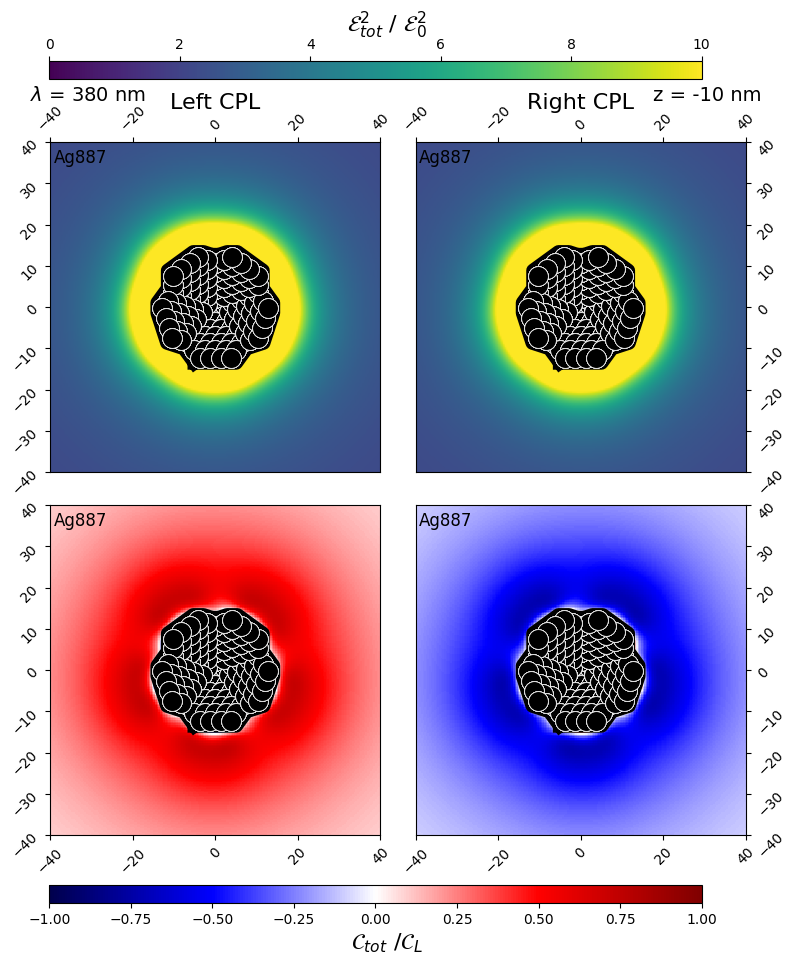

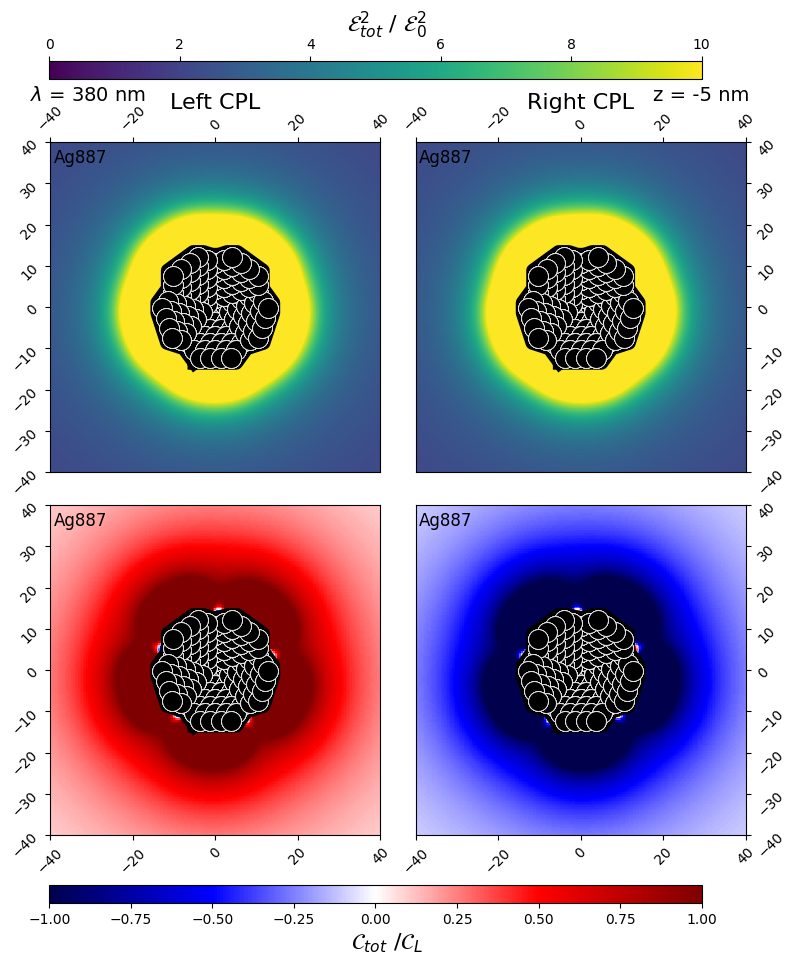

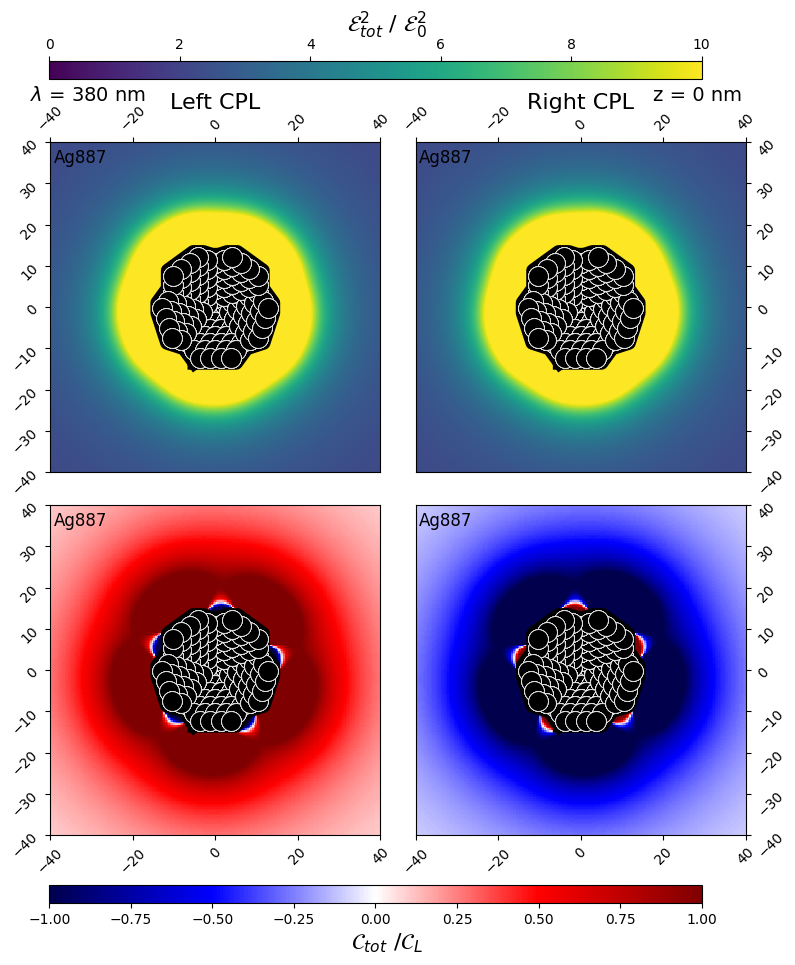

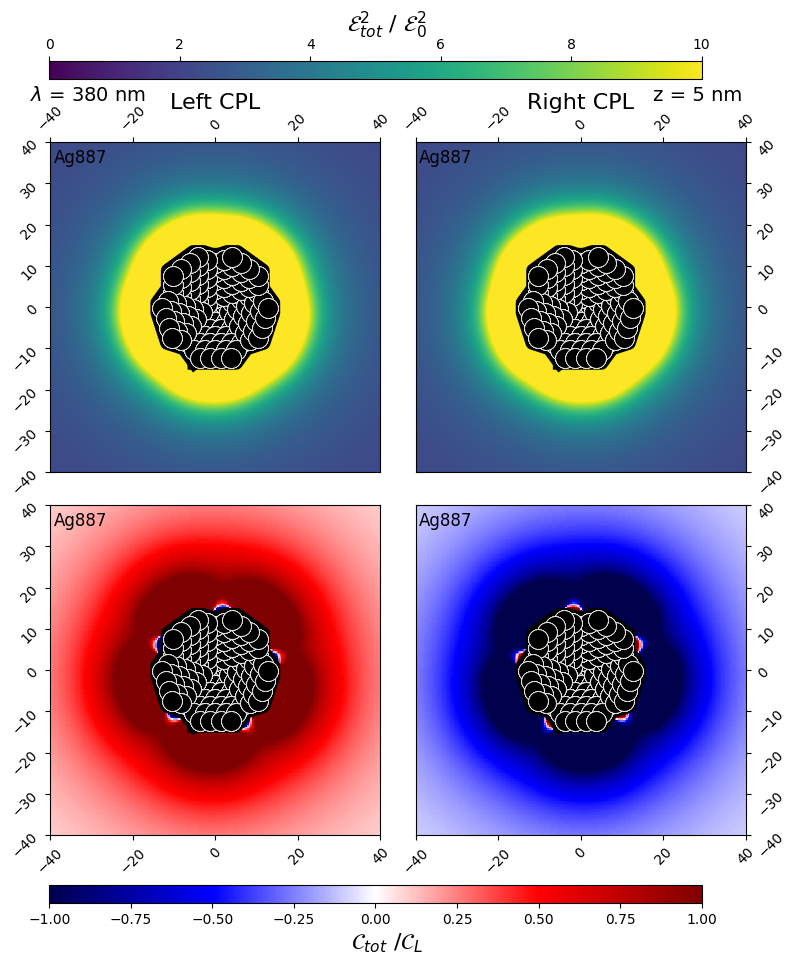

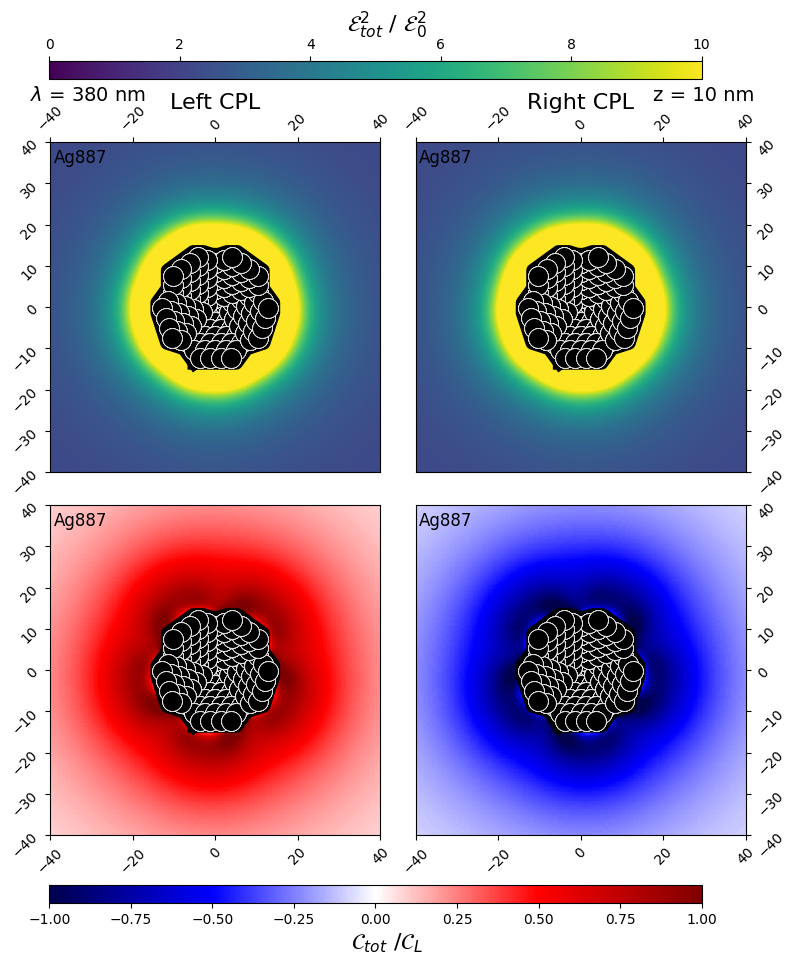

In [24]:
for z in [-10, -5, 0, 5, 10]:
    cmnp_plot(wl_target=380, z_probe=z)
        

In [25]:
def specs_n_peaks(sim, chi = "L",
                  structure = None,
                  x = None,
                  y = None,
                  z = None,
                  ):
    
    if chi.upper() == "L":
        color = "blue"
        lab = "L"
    elif chi.upper() == "R":
        color = "red"
        lab = "R"
    
    field_kwargs = tools.get_possible_field_params_spectra(sim)
    wl, spectrum = tools.calculate_spectrum(sim,field_kwargs[0] , linear.extinct)

    spectrum = spectrum.T

    peaks, _ = find_peaks(spectrum[0], height=0.05*np.amax(spectrum[0]))

    _, Cspec = tools.calculate_spectrum(sim, 
                                        field_kwargs[0], 
                                        linear.optical_chirality, 
                                        r_probe=[[x,y,z]])

    
    if len(peaks) == 0:
        print("No significant peaks found.")
        return wl, spectrum, np.array([]), np.array([])
    else:
        print("Significant local maxima:")
        for peak in peaks:
            print(f"Value: {spectrum[0][peak]}, Index: {peak}")
            
            
        
        return wl, spectrum, peaks, wl[peaks], spectrum[0][peaks], color, lab, Cspec

L_CPL = specs_n_peaks(sim_L, "L",
                      structure=Struct,
                      x=np.amax(Struct.geometry[:,0]) + 1,
                      y=np.amax(Struct.geometry[:,1]) + 1,
                      z=np.amax(Struct.geometry[:,2]) + 1,
                      )
                      
R_CPL = specs_n_peaks(sim_R, "R",
                      structure=Struct,
                      x=np.amax(Struct.geometry[:,0]) + 1,
                      y=np.amax(Struct.geometry[:,1]) + 1,
                      z=np.amax(Struct.geometry[:,2]) + 1,
                      )

def Plot_CD_Only(Save=False, Show=True):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig, ax = plt.subplots(figsize=(6, 2.5), dpi=150)
    
    ax.plot(L_CPL[0], L_CPL[-1] - 2, color=L_CPL[5], label="%s-CPL" % L_CPL[6])  # Left CPL (chirality)
    ax.plot(R_CPL[0], R_CPL[-1] + 2, color=R_CPL[5], label="%s-CPL" % R_CPL[6])  # Right CPL (chirality)

    ax.set_ylabel(r'C / C$_{LCP}$', fontsize=14)
    ax.set_xlabel(r'$\lambda$ [nm]', fontsize=14)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.legend(fontsize=12)
    plt.title(Strut.get_chemical_formula())

    if Save:
        plt.savefig(Save + "_CD.png", dpi=150, bbox_inches='tight')
    elif Show:
        plt.show()
    else:
        plt.close()


Significant local maxima:
Value: 3988.957447048556, Index: 27
Significant local maxima:
Value: 3988.9591255523055, Index: 27


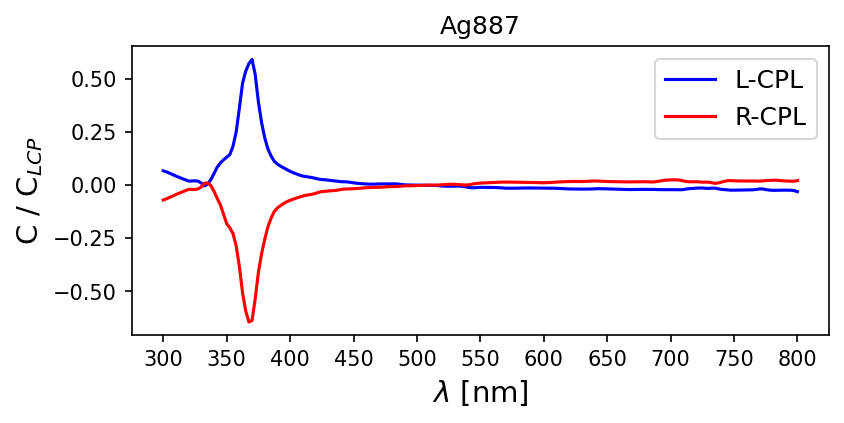

In [26]:
Plot_CD_Only()